## Analisis comparativo entre años

In [1]:
import pandas as pd
import os
import glob
import numpy as np
pd.options.mode.copy_on_write=True

Cargamos todos los dataset limpios:

In [2]:
df_2020 = pd.read_parquet( "../src/data/2020_Accidentalidad_Limpio.parquet", engine="pyarrow" )

df_2021 = pd.read_parquet( "../src/data/2021_Accidentalidad_Limpio.parquet", engine="pyarrow" )

df_2022 = pd.read_parquet( "../src/data/2022_Accidentalidad_Limpio.parquet", engine="pyarrow" )

df_2023 = pd.read_parquet( "../src/data/2023_Accidentalidad_Limpio.parquet", engine="pyarrow" )

df_2024 = pd.read_parquet( "../src/data/2024_Accidentalidad_Limpio.parquet", engine="pyarrow" )



In [3]:
df_2020["origen"] = "2020"
df_2021["origen"] = "2021"
df_2022["origen"] = "2022"
df_2023["origen"] = "2023"
df_2024["origen"] = "2024"


Aqui realizamos concatenacion de los diferentes archivos:

In [8]:
df_accidentes = pd.concat(
    [ df_2020, df_2021, df_2022, df_2023, df_2024],
    ignore_index=True
)


In [9]:
df_accidentes.info()
df_accidentes.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210024 entries, 0 to 210023
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   num_expediente        210024 non-null  object        
 1   fecha                 210024 non-null  datetime64[ns]
 2   hora                  210024 non-null  object        
 3   localizacion          210024 non-null  object        
 4   numero                210024 non-null  object        
 5   distrito              210024 non-null  category      
 6   tipo_accidente        210024 non-null  object        
 7   estado_meteorológico  210024 non-null  object        
 8   tipo_vehiculo         210024 non-null  object        
 9   tipo_persona          210024 non-null  category      
 10  rango_edad            203643 non-null  object        
 11  sexo                  210024 non-null  category      
 12  lesividad             210024 non-null  object        
 13 

,num_expediente,fecha,hora,localizacion,numero,distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,tipo_persona,...,lesividad,coordenada_x_utm,coordenada_y_utm,positiva_alcohol,fecha_hora,franja_horaria,origen,cod_distrito,cod_lesividad,grado_lesividad
0,2019s040008,2020-09-07,23:00:00,"call. san maximiliano, 38",38,CIUDAD LINEAL,Choque contra obstáculo fijo,Despejado,Turismo,Conductor,...,Sin asistencia sanitaria,444578,4475148,Negativo,2020-09-07 23:00:00,Noche,2020,NaN,NaN,NaN
1,2019s040008,2020-09-07,23:00:00,"call. san maximiliano, 38",38,CIUDAD LINEAL,Choque contra obstáculo fijo,Despejado,VMU eléctrico,Conductor,...,Sin asistencia sanitaria,444578,4475148,Negativo,2020-09-07 23:00:00,Noche,2020,NaN,NaN,NaN
2,2020s000001,2020-01-01,01:15:00,avda. canillejas a vicalvaro / call. silfide,1,SAN BLAS-CANILLEJAS,Colisión fronto-lateral,Se desconoce,Turismo,Conductor,...,Sin asistencia sanitaria,447894,4476691,Negativo,2020-01-01 01:15:00,Madrugada,2020,NaN,NaN,NaN
3,2020s000001,2020-01-01,01:15:00,avda. canillejas a vicalvaro / call. silfide,1,SAN BLAS-CANILLEJAS,Colisión fronto-lateral,Se desconoce,Turismo,Conductor,...,Sin asistencia sanitaria,447894,4476691,Positivo,2020-01-01 01:15:00,Madrugada,2020,NaN,NaN,NaN
4,2020s000002,2020-01-01,01:20:00,"call. silvano, 31",31,HORTALEZA,Choque contra obstáculo fijo,Despejado,Turismo,Conductor,...,Sin asistencia sanitaria,445094,4478370,Negativo,2020-01-01 01:20:00,Madrugada,2020,NaN,NaN,NaN


In [10]:
def preparar_accidentes_unicos(df, col_id='num_expediente'):
    """
    Devuelve un DataFrame con accidentes únicos (1 fila = 1 expediente),
    agregando variables relevantes y derivando variables temporales.
    """

    # Asegurar datetime
    df['fecha_hora'] = pd.to_datetime(df['fecha_hora'], errors='coerce')

    # Agregación por expediente
    df_unicos = df.groupby(col_id).agg({
        'fecha_hora': 'min',
        'tipo_accidente': 'first',
        'tipo_vehiculo': lambda x: list(x.unique()),
        'distrito': 'first',
        'estado_meteorológico': 'first',
        'rango_edad': 'first',
        'tipo_persona': 'first',
        'sexo': 'first',
        'positiva_alcohol': 'first'
    }).reset_index()

    # Variables temporales
    df_unicos['año'] = df_unicos['fecha_hora'].dt.year
    df_unicos['mes'] = df_unicos['fecha_hora'].dt.month
    df_unicos['dia_semana'] = df_unicos['fecha_hora'].dt.day_name()
    df_unicos['hora'] = df_unicos['fecha_hora'].dt.hour

    df_unicos['franja'] = pd.cut(
        df_unicos['hora'],
        bins=[0,6,12,18,24],
        labels=['Madrugada','Mañana','Tarde','Noche'],
        right=False
    )

    return df_unicos


In [11]:
import matplotlib.pyplot as plt
import pandas as pd

def curva_mensual_multianual(df, col_datetime="fecha_hora"):
    """
    Genera una única gráfica con la frecuencia mensual de accidentes,
    mostrando una línea por cada año presente en el DataFrame.
    """

    # Asegurar datetime
    df[col_datetime] = pd.to_datetime(df[col_datetime], errors="coerce")

    # Agrupar por año y mes → tabla año × mes
    tabla = (
        df.groupby([df[col_datetime].dt.year, df[col_datetime].dt.month])
          .size()
          .unstack(fill_value=0)
    )

    # Nombres de meses
    meses_es = [
        "Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio",
        "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"
    ]
    tabla.columns = meses_es[:len(tabla.columns)]

    # Crear figura
    plt.figure(figsize=(14, 6))

    # Dibujar una línea por año
    for año in tabla.index:
        plt.plot(
            tabla.columns,
            tabla.loc[año],
            marker="o",
            linewidth=3,
            label=str(año)
        )

        # Etiquetas encima de cada punto
        for i, v in enumerate(tabla.loc[año]):
            plt.text(i, v + 5, str(v), ha="center", fontsize=8)

    # Estética
    plt.title("Curva mensual de accidentes por año", fontsize=14)
    plt.xlabel("Mes")
    plt.ylabel("Número de accidentes")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend(title="Año")
    plt.tight_layout()
    plt.show()


- Aqui se puede visualizar el numero de accidente de todos los meses y de cada año 

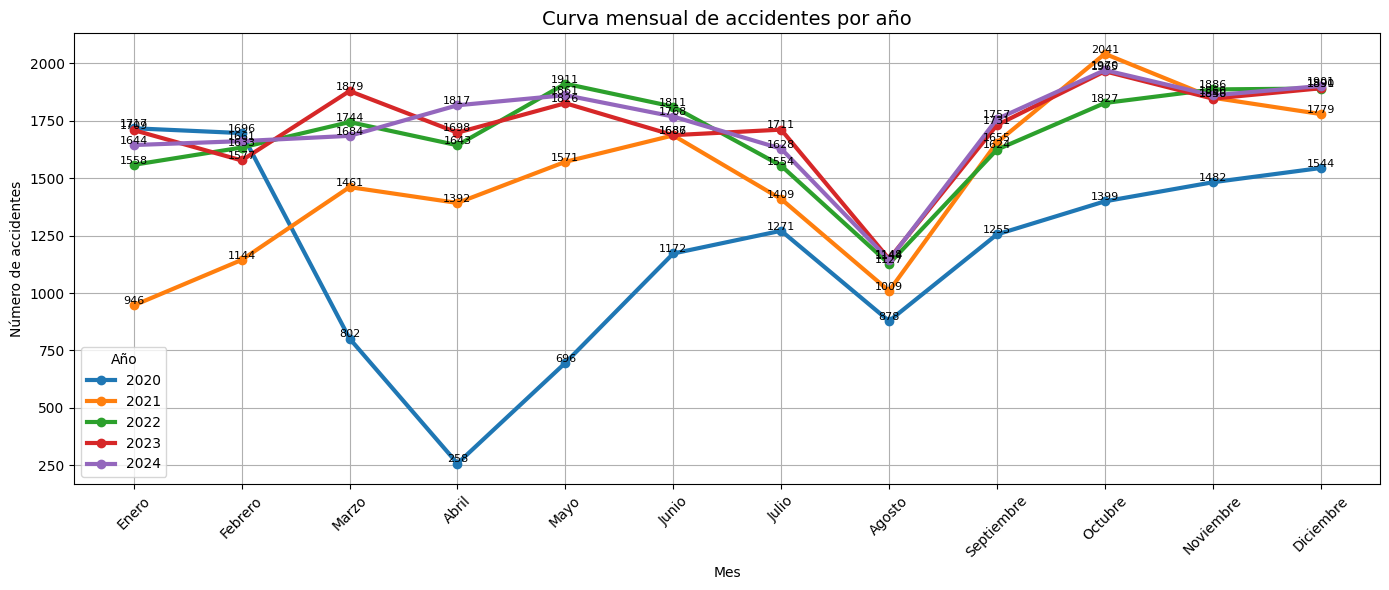

In [12]:
df_unicos = preparar_accidentes_unicos(df_accidentes)
curva_mensual_multianual(df_unicos)


## Conclusiones del análisis temporal de accidentes (2020–2024)
#### 2020: Reducción drástica por confinamiento

- Los meses de marzo y abril presentan mínimos históricos (902 y 356 accidentes respectivamente), coincidiendo con el confinamiento estricto decretado el 14 de marzo del 2020 por la pandemia de COVID-19.

- Esta caída refleja la paralización casi total de la movilidad urbana, lo que confirma la relación directa entre actividad ciudadana y siniestralidad.

#### 2021: Impacto de la tormenta Filomena

- Enero registra solo 946 accidentes, muy por debajo del promedio histórico.

- Este descenso se explica por la tormenta Filomena, que afectó Madrid entre el 6 y el 11 de enero, paralizando el tráfico y la actividad urbana durante varios días.

- A partir de febrero, la accidentalidad se va normalizando, lo que refuerza la hipótesis de que el fenómeno fue puntual y climático.

#### 2022–2024: Estabilidad estructural

- Los tres años muestran curvas mensuales similares, con valores entre 1600 y 1900 accidentes mensuales.

- Se observa una estacionalidad clara: picos en mayo-junio y octubre-noviembre, y valle en agosto debido a las vacaciones de verano.

- Esta regularidad sugiere una fase de estabilización post-pandemia, útil como referencia base para análisis comparativos o proyecciones.

Tendencias generales

- Los eventos externos (COVID y Filomena) tienen un impacto directo y visible en la siniestralidad.

- En ausencia de perturbaciones, la accidentalidad urbana en Madrid sigue patrones estacionales consistentes.

- El análisis por año permite identificar anomalías y contextualizar los datos dentro del marco socio-climático de cada periodo.

In [13]:
def preparar_accidentes_unicos(df, col_id='num_expediente'):
    """
    Devuelve un DataFrame con accidentes únicos (1 fila = 1 accidente),
    agregados por num_expediente y con variables temporales derivadas.
    """

    df = df.copy()

    # Asegurar que fecha_hora es datetime
    df['fecha_hora'] = pd.to_datetime(df['fecha_hora'], errors='coerce')

    # Limpiar tipo_accidente
    df['tipo_accidente_limpio'] = (
        df['tipo_accidente']
        .str.strip()
        .str.lower()
    )

    # Filtrar "no consta"
    df = df[df['tipo_accidente_limpio'] != "no consta"]

    # Agregación por accidente (1 fila = 1 expediente)
    df_unicos = df.groupby(col_id).agg({
        'fecha_hora': 'min',
        'tipo_accidente_limpio': 'first',
        'tipo_vehiculo': lambda x: list(x.unique()),
        'distrito': 'first',
        'estado_meteorológico': 'first',
        'rango_edad': 'first',
        'tipo_persona': 'first',
        'sexo': 'first',
        'positiva_alcohol': 'first'
    }).reset_index()

    # Variables temporales derivadas
    df_unicos['año'] = df_unicos['fecha_hora'].dt.year
    df_unicos['mes'] = df_unicos['fecha_hora'].dt.month
    df_unicos['dia_semana'] = df_unicos['fecha_hora'].dt.day_name()
    df_unicos['hora'] = df_unicos['fecha_hora'].dt.hour

    df_unicos['franja'] = pd.cut(
        df_unicos['hora'],
        bins=[0,6,12,18,24],
        labels=['Madrugada','Mañana','Tarde','Noche'],
        right=False
    )

    return df_unicos


#### Analisis univariante Geográfico

C:\Users\César\AppData\Local\Temp\ipykernel_30612\2341784668.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["distrito", df_all["fecha"].dt.year])["num_expediente"]


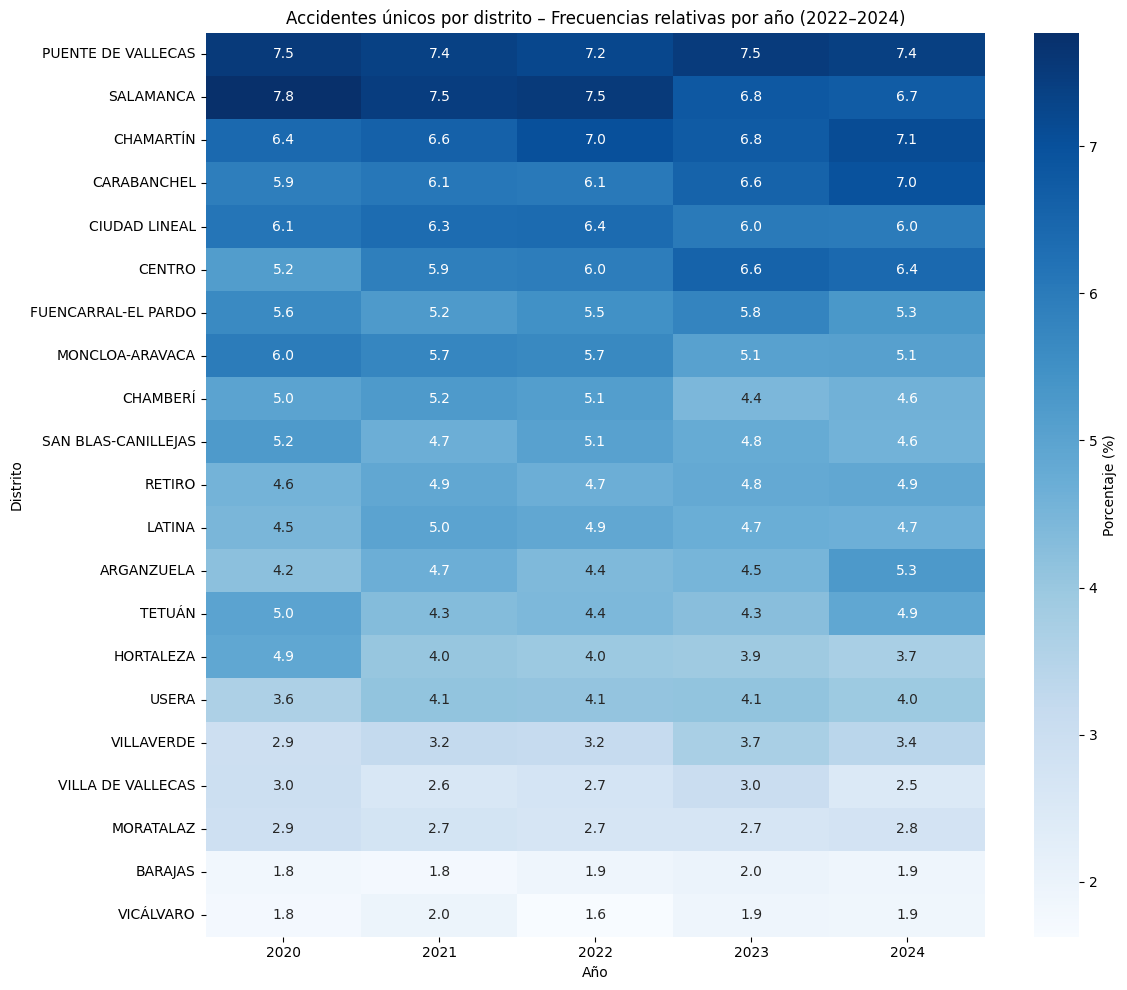

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Filtrar solo 2022–2024 
df_all = df_accidentes.copy()
df_all = df_all[df_all["fecha"].dt.year.isin([2020, 2021, 2022, 2023, 2024])]

# 2. Calcular accidentes únicos por distrito y año 
tabla = (
    df_all
    .groupby(["distrito", df_all["fecha"].dt.year])["num_expediente"]
    .nunique()
    .unstack(fill_value=0)
)

# 3. Convertir a porcentajes por año 
tabla_pct = tabla.apply(lambda col: col / col.sum() * 100, axis=0)

# 4. Ordenar distritos por total de accidentes 
tabla_pct = tabla_pct.loc[tabla.sum(axis=1).sort_values(ascending=False).index]

# 5. Heatmap con AÑOS en X y DISTRITOS en Y 
plt.figure(figsize=(12, 10))
sns.heatmap(
    tabla_pct,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    cbar_kws={"label": "Porcentaje (%)"}
)

plt.title("Accidentes únicos por distrito – Frecuencias relativas por año (2022–2024)")
plt.xlabel("Año")
plt.ylabel("Distrito")
plt.tight_layout()
plt.show()


## Conclusiones del análisis de accidentes por distrito y año
#### Estabilidad estructural en la distribución territorial
- La mayoría de los distritos mantienen porcentajes relativamente estables a lo largo de los cinco años.

- Ejemplo claro: Puente de Vallecas oscila entre 7.2% y 7.5%, lo que indica una persistencia en su peso relativo dentro del total de accidentes.

- Esta estabilidad sugiere que la distribución espacial de la accidentalidad responde a patrones urbanos consolidados (densidad, tráfico, infraestructura).

#### Distritos con mayor carga de accidentalidad
- Centro, Salamanca, Chamartín, Carabanchel, Ciudad Lineal y Puente de Vallecas destacan como los distritos con mayor porcentaje de accidentes únicos.

- Estos distritos combinan alta densidad poblacional, actividad comercial y tráfico intenso, lo que explica su protagonismo en la siniestralidad.

#### Distritos con menor peso relativo
- Barajas, Vicálvaro, Moratalaz, Villa de Vallecas y Usera presentan porcentajes más bajos, generalmente por debajo del 4%.

- Esto puede deberse a menor densidad, menor flujo vehicular o características urbanas menos propensas a la accidentalidad.

#### Variaciones puntuales por año
Aunque la mayoría de los distritos son estables, hay ligeras fluctuaciones que podrían estar asociadas a:

- Obras, cambios en movilidad o infraestructura.

- Eventos climáticos (como Filomena en 2021).

- Cambios en hábitos post-pandemia (2022–2023).

- Ejemplo: Centro baja ligeramente en 2021, posiblemente por menor actividad tras Filomena y restricciones COVID.

#### Utilidad para planificación urbana
Este análisis permite identificar distritos prioritarios para intervenciones de seguridad vial.

Los distritos con mayor carga deberían ser foco de:

- Revisión de señalización.

- Refuerzo de controles.

- Campañas de concienciación.

- Mejora de infraestructura peatonal y ciclista.

#### Analisis Univariante por tipo de accidente

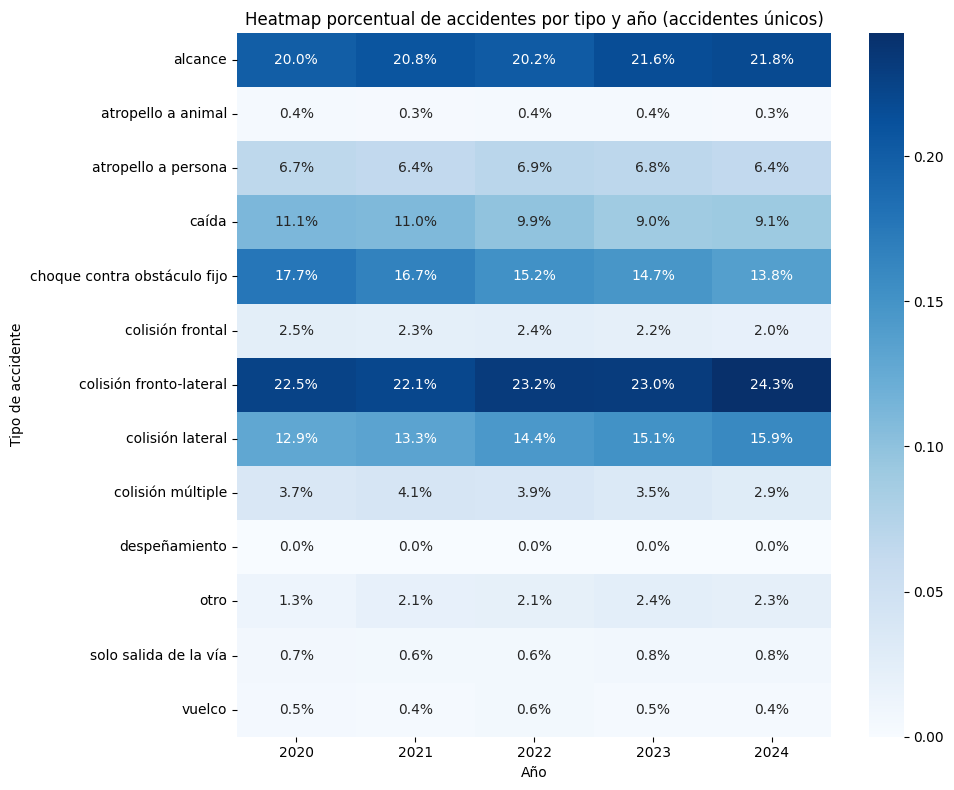

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Preparar accidentes únicos
df_accidentes_unicos = preparar_accidentes_unicos(df_accidentes)

# 2. Filtrar años de interés
df_plot = df_accidentes_unicos[df_accidentes_unicos["año"].isin([2020, 2021, 2022, 2023, 2024])]

# 3. Tabla año × tipo_accidente (conteos)
tabla = (
    df_plot
    .pivot_table(
        index="tipo_accidente_limpio",
        columns="año",
        aggfunc="size",
        fill_value=0
    )
)

# 4. Convertir a porcentajes por año
tabla_pct = tabla.apply(lambda col: col / col.sum(), axis=0)

# 5. Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(
    tabla_pct,
    annot=True,
    fmt=".1%",
    cmap="Blues"
)

plt.title("Heatmap porcentual de accidentes por tipo y año (accidentes únicos)")
plt.xlabel("Año")
plt.ylabel("Tipo de accidente")
plt.tight_layout()
plt.show()


## Conclusiones del análisis por tipo de accidente (2020–2024)
#### Tipos de accidente más frecuentes
- Colisión fronto-lateral es el tipo más común en todos los años, con un crecimiento sostenido: del 22.5% en 2020 al 24.3% en 2024.
- Le siguen alcance (21.8% en 2024) y colisión lateral (15.9% en 2024), ambos también con tendencia ascendente.
- Estos tres tipos representan más del 60% de los accidentes únicos, lo que sugiere que la mayoría de siniestros ocurren en contextos de interacción entre vehículos en movimiento.

#### Descenso progresivo en accidentes por choque contra obstáculo fijo
- De 17.7% en 2020 a 13.8% en 2024, con una caída constante año a año.
- Esto podría reflejar mejoras en señalización, visibilidad, o infraestructura urbana que reduce este tipo de colisiones.

#### Estabilidad en atropellos a persona
- Oscila entre 6.4% y 6.9% sin una tendencia clara.
- Aunque no crece, su persistencia indica que sigue siendo un tipo crítico para la seguridad peatonal.

#### Caídas: descenso sostenido
- De 11.1% en 2020 a 9.0% en 2023, con leve repunte en 2024 (9.1%).
- Posible relación con mejoras en pavimento, condiciones meteorológicas o campañas de prevención.

#### Analisdis Univariante por tipo de persona implicada en los accidente y por vehiculos

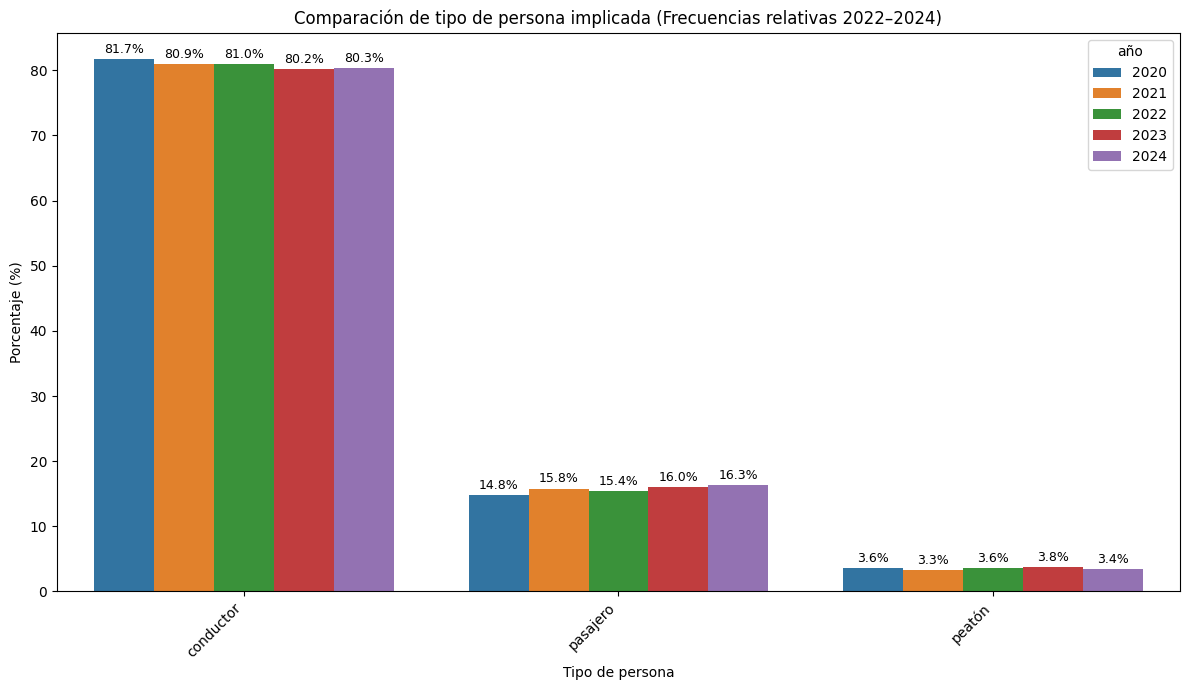

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# 0. Crear columna año si no existe
if "año" not in df_accidentes.columns:
    df_accidentes["año"] = df_accidentes["fecha"].dt.year

# 1. Filtrar solo 2022–2024 
df_personas = df_accidentes[df_accidentes["año"].isin([2020, 2021, 2022, 2023, 2024])]

# 2. Limpiar tipo_persona 
df_personas["tipo_persona_limpio"] = (
    df_personas["tipo_persona"]
    .str.strip()
    .str.lower()
)

# 3. Frecuencias absolutas por año y tipo_persona 
tabla = (
    df_personas
    .groupby(["año", "tipo_persona_limpio"])
    .size()
    .reset_index(name="n")
)

# 4. Calcular porcentajes por año 
tabla["porcentaje"] = (
    tabla.groupby("año")["n"].transform(lambda x: x / x.sum() * 100)
)

# 5. Crear gráfico comparativo 
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    data=tabla,
    x="tipo_persona_limpio",
    y="porcentaje",
    hue="año",
    palette="tab10"
)

plt.title("Comparación de tipo de persona implicada (Frecuencias relativas 2022–2024)")
plt.ylabel("Porcentaje (%)")
plt.xlabel("Tipo de persona")
plt.xticks(rotation=45, ha="right")

# 6. Añadir etiquetas encima de cada barra
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        x = p.get_x() + p.get_width() / 2
        ax.text(
            x,
            height + 0.5,
            f"{height:.1f}%",
            ha="center",
            va="bottom",
            fontsize=9
        )

plt.tight_layout()
plt.show()


## Conclusiones del análisis por tipo de persona implicada (2020–2024)
#### Predominio constante del conductor
- Los conductores representan sistemáticamente más del 80% de las personas implicadas en accidentes cada año.
- Este dato refleja que la mayoría de los siniestros involucran directamente a quien maneja el vehículo, lo que refuerza la necesidad de focalizar las políticas de seguridad vial en este grupo.

#### Ligero aumento de pasajeros
- El porcentaje de pasajeros ha crecido de 14.8% en 2020 a 16.3% en 2024, con una tendencia ascendente sostenida.
- Esto podría estar relacionado con un aumento en la movilidad compartida (vehículos privados, taxis, VTC) o con cambios en los patrones de desplazamiento post-pandemia.

#### Estabilidad en peatones
- Los peatones se mantienen en torno al 3.3%–3.8%, sin variaciones significativas.
- Aunque su peso relativo es bajo, su vulnerabilidad es alta, por lo que siguen siendo un grupo prioritario en términos de protección y diseño urbano.

#### Tendencia general: estabilidad estructural
- No se observan cambios bruscos ni anomalías interanuales.
- Esto sugiere que la distribución por tipo de persona implicada responde a patrones de movilidad consolidados en Madrid.

#### Implicaciones para la gestión urbana
- Las estrategias de prevención deben centrarse en:
- Formación y control de conductores.
- Seguridad pasiva en vehículos (cinturones, airbags, etc.).
- Infraestructura peatonal segura y bien señalizada.
- El crecimiento de pasajeros podría justificar campañas específicas sobre comportamiento dentro del vehículo y uso de sistemas de retención.

#### Analisis Univariante Demografico teniendo en cuenta los conductores

C:\Users\César\AppData\Local\Temp\ipykernel_30612\2596743179.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["rango_edad", df_conductores["fecha"].dt.year])


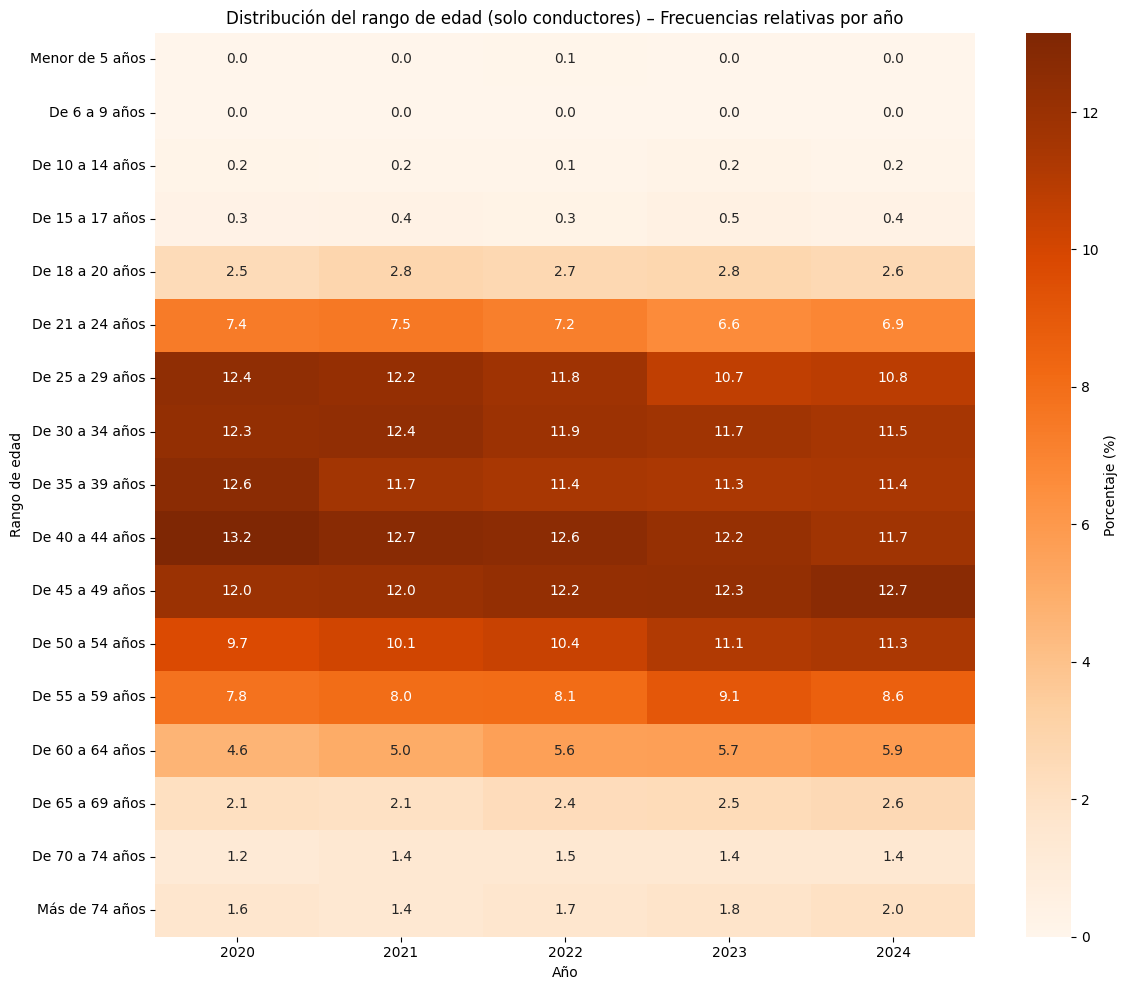

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Filtrar solo 2022–2024 
df_all = df_accidentes.copy()
df_all = df_all[df_all["fecha"].dt.year.isin([2020, 2021, 2022, 2023, 2024])]

# 2. Filtrar solo conductores 
df_conductores = df_all[
    df_all["tipo_persona"].str.strip().str.lower() == "conductor"
]

# 3. Eliminar "desconocido" 
df_conductores = df_conductores[
    df_conductores["rango_edad"].str.strip().str.lower() != "desconocido"
]

# 4. Orden correcto de rangos de edad 
orden_edad = [
    "Menor de 5 años",
    "De 6 a 9 años",
    "De 10 a 14 años",
    "De 15 a 17 años",
    "De 18 a 20 años",
    "De 21 a 24 años",
    "De 25 a 29 años",
    "De 30 a 34 años",
    "De 35 a 39 años",
    "De 40 a 44 años",
    "De 45 a 49 años",
    "De 50 a 54 años",
    "De 55 a 59 años",
    "De 60 a 64 años",
    "De 65 a 69 años",
    "De 70 a 74 años",
    "Más de 74 años"
]

df_conductores["rango_edad"] = (
    df_conductores["rango_edad"]
    .str.strip()
    .astype("category")
    .cat.set_categories(orden_edad, ordered=True)
)

# 5. Crear tabla año × rango_edad 
tabla = (
    df_conductores
    .groupby(["rango_edad", df_conductores["fecha"].dt.year])
    .size()
    .unstack(fill_value=0)
)
# 6. Convertir a porcentajes por año 
tabla_pct = tabla.apply(lambda col: col / col.sum() * 100, axis=0)

# 7. Heatmap 
plt.figure(figsize=(12, 10))
sns.heatmap(
    tabla_pct,
    annot=True,
    fmt=".1f",
    cmap="Oranges",
    cbar_kws={"label": "Porcentaje (%)"}
)

plt.title("Distribución del rango de edad (solo conductores) – Frecuencias relativas por año")
plt.xlabel("Año")
plt.ylabel("Rango de edad")
plt.tight_layout()
plt.show()


## Conclusiones del análisis de edad de conductores implicados (2020–2024)
#### Predominio de conductores entre 30 y 54 años
- Los grupos de edad 30–34, 35–39, 40–44, 45–49 y 50–54 años concentran los mayores porcentajes de conductores implicados en accidentes.
- Este bloque intermedio representa el núcleo activo de la movilidad urbana, con porcentajes que oscilan entre 9% y 13% según el año y el grupo.
- La estabilidad de estos valores sugiere que la siniestralidad está fuertemente ligada a los grupos con mayor presencia en el parque móvil y en la actividad laboral.

#### Mínima implicación de menores de edad
- Los grupos menor de 5 años, 6–9, 10–14 y 15–17 años tienen porcentajes prácticamente nulos.
- Esto confirma que los menores no figuran como conductores en los registros, lo cual es esperable y coherente con la normativa.

#### Conductores mayores: presencia moderada y estable
- Los grupos 60–64, 63–69, 70–74 y más de 74 años mantienen porcentajes bajos pero constantes.
- Aunque no son los más implicados, su presencia es relevante para políticas de conducción sénior, revisión médica y adaptación de infraestructura.

#### Descenso progresivo en el grupo 25–29 años
- Este grupo muestra una ligera caída en su porcentaje a lo largo del periodo.
- Podría estar relacionado con cambios en hábitos de movilidad (más uso de transporte público, VTC o bicicleta) o con factores socioeconómicos que retrasan el acceso al vehículo propio.

#### Estabilidad general en la estructura etaria
- No se observan cambios bruscos ni anomalías interanuales.
- La distribución por edad se mantiene relativamente constante, lo que permite usar estos datos como referencia base para análisis comparativos o proyecciones.

#### Implicaciones para la gestión urbana
- Las campañas de seguridad vial deberían centrarse en los grupos de mayor implicación (30–54 años), sin descuidar a los conductores mayores.
- La baja participación de jóvenes y mayores en accidentes como conductores no implica menor vulnerabilidad como peatones o pasajeros, por lo que deben considerarse en análisis multivariables.

C:\Users\César\AppData\Local\Temp\ipykernel_30612\2805176102.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["año", "sexo_limpio"])


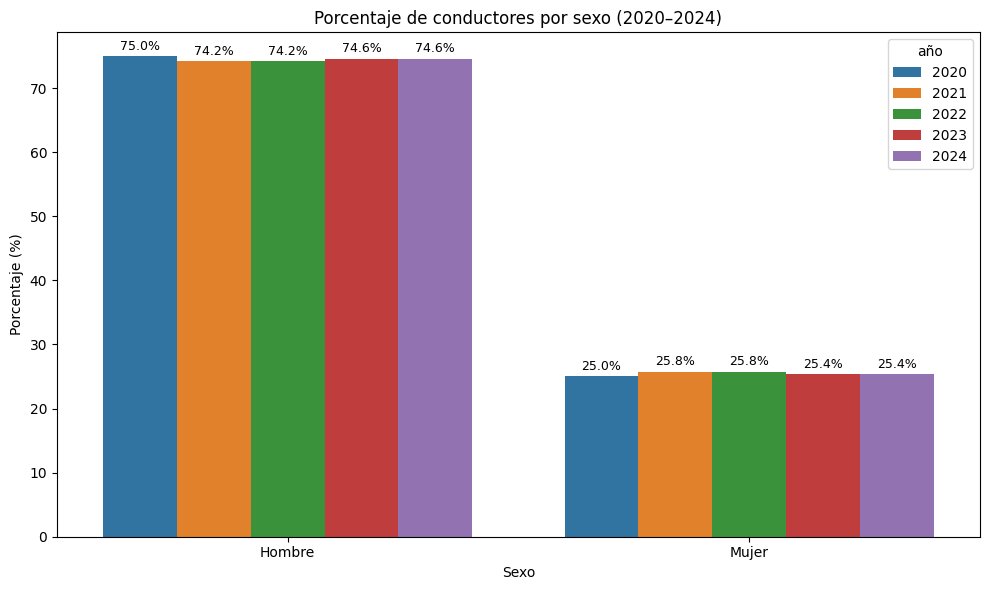

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# 0. Crear columna año si no existe
df_accidentes["año"] = df_accidentes["fecha"].dt.year

# 1. Filtrar solo 2020–2024 
df_all = df_accidentes.copy()
df_all = df_all[df_all["año"].isin([2020, 2021, 2022, 2023, 2024])]

# 2. Filtrar solo conductores 
df_conductores = df_all[
    df_all["tipo_persona"].str.strip().str.lower() == "conductor"
]

# 3. Eliminar "desconocido" 
df_conductores = df_conductores[
    df_conductores["sexo"].str.strip().str.lower() != "desconocido"
]

# 4. Normalizar categorías 
df_conductores["sexo_limpio"] = (
    df_conductores["sexo"]
    .str.strip()
    .str.capitalize()
)

orden_sexo = ["Hombre", "Mujer"]
df_conductores["sexo_limpio"] = (
    df_conductores["sexo_limpio"]
    .astype("category")
    .cat.set_categories(orden_sexo, ordered=True)
)

# 5. Frecuencias absolutas por año y sexo 
tabla = (
    df_conductores
    .groupby(["año", "sexo_limpio"])
    .size()
    .reset_index(name="n")
)

# 6. Convertir a porcentajes por año 
tabla["porcentaje"] = (
    tabla.groupby("año")["n"].transform(lambda x: x / x.sum() * 100)
)

# 7. Gráfico SOLO relativo 
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=tabla,
    x="sexo_limpio",
    y="porcentaje",
    hue="año",
    palette="tab10"
)

plt.title("Porcentaje de conductores por sexo (2020–2024)")
plt.ylabel("Porcentaje (%)")
plt.xlabel("Sexo")
plt.xticks(rotation=0)

# 8. Etiquetas encima de cada barra (solo si > 0) 
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        x = p.get_x() + p.get_width() / 2
        ax.text(
            x,
            height + 0.5,
            f"{height:.1f}%",
            ha="center",
            va="bottom",
            fontsize=9
        )

plt.tight_layout()
plt.show()


## Conclusiones del análisis por sexo de conductores implicados (2020–2024)
#### Predominio masculino constante
- Los hombres representan sistemáticamente alrededor del 74–75% de los conductores implicados en accidentes cada año.
- Esta proporción se mantiene estable, lo que indica que la siniestralidad está dominada por el grupo masculino, en línea con su mayor presencia en la conducción urbana.

#### Participación femenina estable y creciente
- Las mujeres representan entre 25.0% y 25.8%, con un ligero repunte en 2021 y 2022.
- Aunque la diferencia con los hombres es notable, la participación femenina muestra una tendencia a estabilizarse en torno al 25%, lo que puede reflejar una mayor incorporación de mujeres a la conducción activa.

#### Ausencia de variaciones significativas
- No se observan cambios bruscos ni anomalías interanuales. 
- Esto sugiere que la distribución por sexo en la conducción se mantiene estructuralmente estable en Madrid durante el periodo analizado.

#### Implicaciones para la seguridad vial
- Las campañas de prevención deben considerar el perfil mayoritario masculino, especialmente en franjas de edad y tipos de accidente donde su implicación sea más alta.
- También conviene analizar si existen diferencias en el tipo de siniestro o lesividad según el sexo, para diseñar intervenciones más específicas.

#### Analisis de Lesividad 

C:\Users\César\AppData\Local\Temp\ipykernel_30612\2851570114.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["año", "lesividad_legible"])


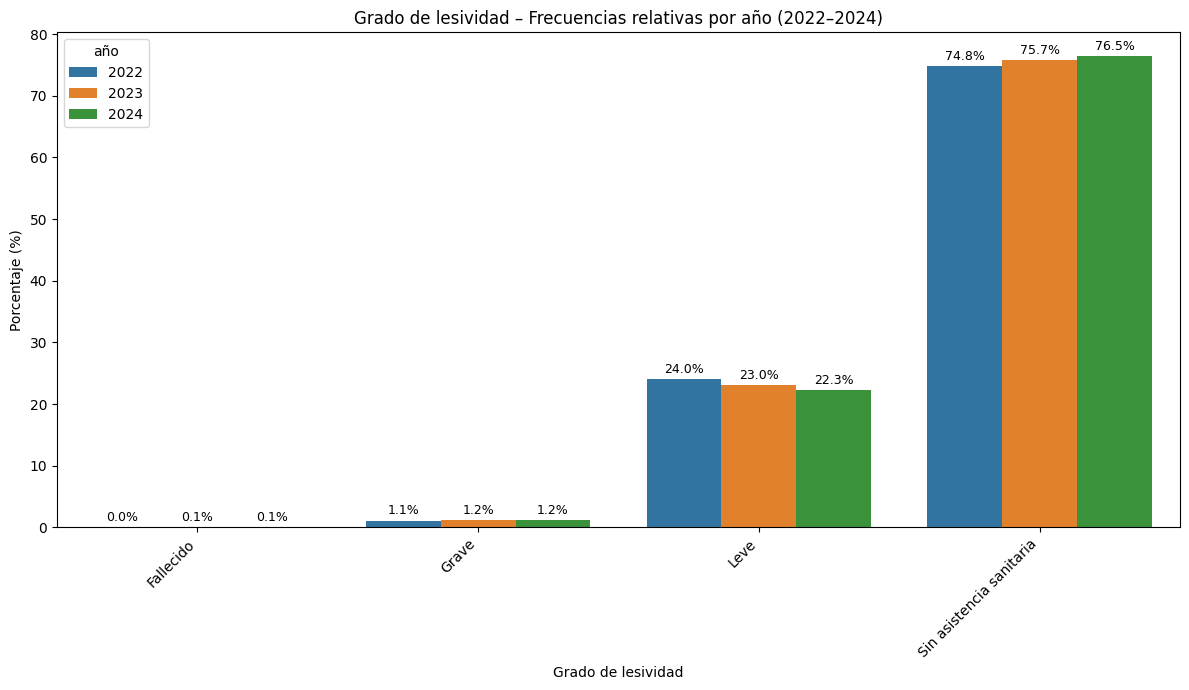

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
import re

# Función de limpieza profunda 
def limpiar_texto(x):
    x = str(x)
    x = unicodedata.normalize("NFKC", x)
    x = x.replace("\u00A0", " ")
    x = re.sub(r"\s+", " ", x)
    return x.strip().lower()

# 1. Filtrar solo 2022–2024 
df_all = df_accidentes.copy()
df_all = df_all[df_all["fecha"].dt.year.isin([2022, 2023, 2024])]

# 2. Normalizar columna de lesividad 
df_all["lesividad_limpia"] = df_all["grado_lesividad"].apply(limpiar_texto)

# 3. Excluir "no consta" y "se desconoce" 
valores_excluir = ["no consta", "se desconoce"]
df_all = df_all[~df_all["lesividad_limpia"].isin(valores_excluir)]

# 4. Mapear nombres legibles 
etiquetas_legibles = {
    "sin asistencia sanitaria": "Sin asistencia sanitaria",
    "leve": "Leve",
    "grave": "Grave",
    "fallecido": "Fallecido"
}

df_all["lesividad_legible"] = df_all["lesividad_limpia"].map(
    lambda x: etiquetas_legibles.get(x, x.title())
)

# 5. Frecuencias absolutas por año y lesividad 
tabla = (
    df_all
    .groupby(["año", "lesividad_legible"])
    .size()
    .reset_index(name="n")
)

# 6. Convertir a porcentajes por año 
tabla["porcentaje"] = (
    tabla.groupby("año")["n"].transform(lambda x: x / x.sum() * 100)
)

# 6.1 Eliminar cualquier rastro de "se desconoce" 
tabla = tabla[~tabla["lesividad_legible"].str.lower().str.contains("desconoce")]

# 6.2 Convertir a string para eliminar categorías residuales 
tabla["lesividad_legible"] = tabla["lesividad_legible"].astype(str)

# 7. Gráfico SOLO relativo 
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    data=tabla,
    x="lesividad_legible",
    y="porcentaje",
    hue="año",
    palette="tab10"
)

plt.title("Grado de lesividad – Frecuencias relativas por año (2022–2024)")
plt.ylabel("Porcentaje (%)")
plt.xlabel("Grado de lesividad")
plt.xticks(rotation=45, ha="right")

# 8. Etiquetas encima de cada barra (solo si > 0)
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # ← evita mostrar 0.0%
        x = p.get_x() + p.get_width() / 2
        ax.text(
            x,
            height + 0.5,
            f"{height:.1f}%",
            ha="center",
            va="bottom",
            fontsize=9
        )

plt.tight_layout()
plt.show()


## Conclusiones del análisis de lesividad (2022–2024)
#### Predominio de casos sin asistencia sanitaria
- La categoría “Sin asistencia sanitaria” representa la mayoría de los casos cada año, con un crecimiento sostenido:
- 74.8% en 2022,
- 75.7% en 2023,
- 76.5% en 2024.

- Esto puede reflejar accidentes de baja intensidad, donde los implicados no requieren atención médica o no la solicitan. También podría indicar subregistro de lesiones leves.

#### Descenso progresivo de lesiones leves
- a categoría “Leve” desciende de 24.0% en 2022 a 22.3% en 2024.
- Esta caída puede estar relacionada con mejoras en seguridad pasiva (cinturones, airbags), reducción de velocidad media o cambios en el tipo de colisión predominante.

#### Lesiones graves: baja incidencia pero estable
- La categoría “Grave” se mantiene en torno al 1.1–1.2%, sin variaciones significativas.
- Aunque minoritaria, esta categoría es crítica para la gestión hospitalaria y la planificación de recursos de emergencia.

#### Fallecimientos: mínimos pero presentes
- En 2022 no se registran fallecidos, pero en 2023 y 2024 aparece un 0.1%, lo que indica que los accidentes mortales, aunque excepcionales, siguen ocurriendo.
- Estos casos deben ser analizados individualmente para identificar factores de riesgo estructurales o conductuales.

#### Tendencia general: menor lesividad clínica
- El aumento de casos sin asistencia y el descenso de lesiones leves sugieren una posible reducción en la gravedad clínica de los accidentes.
- Esto podría deberse a mejoras en infraestructura, vehículos más seguros o cambios en el comportamiento vial.

#### Implicaciones para la gestión urbana
Las estrategias deben enfocarse en:

- Mejorar el registro de lesiones leves para evitar subestimaciones.
- Analizar los casos sin asistencia para entender si son realmente leves o hay barreras de acceso.
- Mantener vigilancia sobre los casos graves y mortales, aunque sean pocos.

#### Analisis Univariante de Alcohol

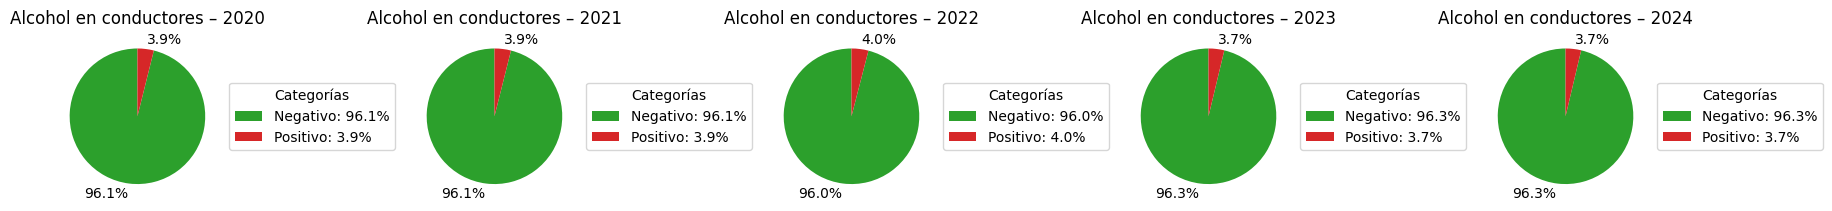

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Filtrar solo conductores de 2022–2024 
df_all = df_accidentes.copy()
df_all = df_all[df_all["fecha"].dt.year.isin([2020, 2021, 2022, 2023, 2024])]

df_conductores = df_all[
    df_all["tipo_persona"].str.lower().str.strip() == "conductor"
]

# 2. Normalizar columna de alcohol 
alcohol_col = (
    df_conductores["positiva_alcohol"]
    .astype(str)
    .str.strip()
    .str.lower()
)

# 3. Excluir "no consta" 
alcohol_col = alcohol_col[alcohol_col != "no consta"]

# 4. Añadir columna limpia al dataframe 
df_conductores = df_conductores.loc[alcohol_col.index].copy()
df_conductores["alcohol_limpio"] = alcohol_col

# 5. Paleta de colores personalizada 
color_map = {
    "positivo": "#d62728",   # rojo
    "negativo": "#2ca02c",   # verde
}

# 6. Crear figura con 3 tartas (una por año) 
fig, axes = plt.subplots(1, 5, figsize=(18, 6))

for ax, year in zip(axes, [2020, 2021, 2022, 2023, 2024]):

    df_year = df_conductores[df_conductores["fecha"].dt.year == year]

    # Frecuencias relativas
    rel_freq = df_year["alcohol_limpio"].value_counts(normalize=True) * 100

    # Colores en el orden correcto
    colors = [color_map.get(cat, "#999999") for cat in rel_freq.index]

    # Pie chart sin etiquetas internas
    wedges, _ = ax.pie(
        rel_freq,
        labels=None,
        autopct=None,
        startangle=90,
        colors=colors,
        radius=1
    )

    ax.set_title(f"Alcohol en conductores – {year}")

    # Etiquetas externas
    for wedge, pct in zip(wedges, rel_freq.values):
        angle = (wedge.theta2 + wedge.theta1) / 2
        x = np.cos(np.deg2rad(angle))
        y = np.sin(np.deg2rad(angle))
        label_x = 1.15 * x
        label_y = 1.15 * y
        ha = "left" if x > 0 else "right"
        ax.text(label_x, label_y, f"{pct:.1f}%", ha=ha, va="center", fontsize=10)

    # Leyenda
    legend_labels = [
        f"{cat.capitalize()}: {pct:.1f}%"
        for cat, pct in zip(rel_freq.index, rel_freq.values)
    ]

    ax.legend(
        wedges,
        legend_labels,
        title="Categorías",
        loc="center left",
        bbox_to_anchor=(1, 0.5)
    )

plt.tight_layout()
plt.show()


## Conclusiones del análisis de alcohol en conductores (2020–2024)
#### Predominio absoluto de resultados negativos
- En todos los años analizados, más del 96% de los conductores implicados en accidentes dieron negativo en la prueba de alcohol.
- Esto sugiere que la mayoría de los siniestros no están directamente relacionados con consumo de alcohol, al menos según los registros disponibles.

#### Presencia de alcohol: estable y minoritaria
- El porcentaje de positivos oscila entre 3.7% y 4.0%, sin variaciones significativas.
- Aunque bajo, este dato es relevante: implica que 1 de cada 25 conductores implicados en accidentes había consumido alcohol, lo que representa un riesgo crítico por su potencial de gravedad.

#### Ligero descenso en positivos en los últimos años
- De 4.0% en 2022 a 3.7% en 2023 y 2024, lo que podría reflejar:
- Mayor control policial.
- Campañas de concienciación.
- Cambios en hábitos de consumo y movilidad nocturna.

#### Implicaciones para la seguridad vial
- Aunque los positivos son minoría, su impacto puede ser desproporcionado en términos de gravedad y mortalidad.
- Las estrategias deben seguir reforzando: 
- Controles aleatorios.
- Educación vial sobre alcohol y conducción.
- Alternativas seguras de transporte nocturno.